In [1]:
import pandas as pd
import numpy as np
import pytimetk as tk
import seaborn as sns
import holidays as ho

In [2]:
raw_df=pd.read_csv('mediamix_sales.csv')
raw_df['Time'] = pd.to_datetime(raw_df['Time'], format='%d/%m/%y').dt.to_period('M')

In [3]:
cpi_df = pd.read_csv('M213751.csv', header=9, skipfooter=26, names=['period', 'cpi_all_raw'])
cpi_df['period'] = pd.to_datetime(cpi_df['period'], format='    %Y %b').dt.to_period('M')

# Mixed Media Model Notebook

In this notebook, my hope is to showcase ongoing efforts to learn about Media Mixed Model methods as applied using PYMC and how they can be utilized in real world cases. I have chosen to work with a data set taken from kaggel for this exercise rather than creating a simulated set as perfectly formed and presented data is not always available from clients.

## Description of Data
### Source(s)
- Client Data: [https://www.kaggle.com/datasets/mediaearth/traditional-and-digital-media-impact-on-sales](https://www.kaggle.com/datasets/mediaearth/traditional-and-digital-media-impact-on-sales)
- CPI: Singapore Department of Statisitcs https://tablebuilder.singstat.gov.sg/table/TS/M213751
- Holidays: Python Holidays Package
### Period
- Monthly Intervals from 1/01 to 08/17 (200 observations total)
### Media Variables
- tv_sponsorships
- tv_cricket: this is likely spending on match sponsorship
- tv_RON
- radio 
- NPP 
- Magazines 
- OOH: Out Of Home Spend (Billboards, ect.) 
- Social: Social Media Spend 
- Programmatic 
- Display_Rest 
- Search: As the client did not specify if this was a count of search engine clicks or spending on search engine clicks, we will have to run models under both assumptions and compare 
- Native 
### Target Variable
- sales
## Inferences
- Looking at the kaggle profile of the creator of this data set, we can infer that the data is probably created with a Singapore based company and ad campaign in mind. This allows us to bring in CPI data from the IMF to further enhance this analysis as we can use that to help separate economic conditions from the effects we are trying to observe..


## Exploring The Data

In [4]:
raw_df.head()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales
0,2001-01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100
1,2001-02,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400
2,2001-03,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300
3,2001-04,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500
4,2001-05,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900


Let us now bring in some data on Singapore holidays as that may have some additional impact on sales. The next few cells will create a table of singaporean holiday dates and we will then combine that into a column that will yeild the number of holidays in a given month.

In [5]:
sg_holidays = [(d,h) for d,h in ho.SG(years=range(2001, 2018), observed=False).items()]
sg_ho_df = pd.DataFrame(sg_holidays, columns=['date', 'holiday'])
sg_ho_df['date'] = pd.to_datetime(sg_ho_df['date']).dt.to_period('M')
sg_ho_df.head()
#sg_ho_df.groupby('date')['holiday'].sum()

,date,holiday
0,2016-01,New Year's Day
1,2016-02,Chinese New Year
2,2016-02,Chinese New Year
3,2016-07,Eid al-Fitr
4,2016-09,Eid al-Adha


In [6]:
cpi_df.head()

,period,cpi_all_raw
0,2001-01,64.8
1,2001-02,64.7
2,2001-03,64.8
3,2001-04,65.0
4,2001-05,64.7


In [7]:
sg_ho_du_df = pd.get_dummies(sg_ho_df, columns=['holiday'], prefix='', prefix_sep='', dtype=int).sort_values(by='date').drop_duplicates().groupby(['date'], as_index=False).sum()

In [8]:
holiday_names = sg_ho_du_df.iloc[:,1:].columns.tolist()

In [9]:
#to make sure there are no non-binary variables in error
for col in sg_ho_du_df:
    print(sg_ho_du_df[col].unique())

<PeriodArray>
['2001-01', '2001-03', '2001-04', '2001-05', '2001-08', '2001-11', '2001-12',
 '2002-01', '2002-02', '2002-03',
 ...
 '2016-10', '2016-12', '2017-01', '2017-04', '2017-05', '2017-06', '2017-08',
 '2017-09', '2017-10', '2017-12']
Length: 131, dtype: period[M]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[0 1]
[1 0]
[0 1]
[0 1]
[0 1]


In [77]:
data_df = raw_df.merge(sg_ho_du_df, how='left', left_on='Time', right_on='date').drop('date', axis=1).fillna(0)
data_df = data_df.merge(cpi_df, how='left', left_on='Time', right_on='period').drop('period', axis=1)
data_df.head()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales,Chinese New Year,Christmas Day,Deepavali,Eid al-Adha,Eid al-Fitr,Good Friday,Labor Day,National Day,New Year's Day,Polling Day,SG50 Public Holiday,Vesak Day,cpi_all_raw
0,2001-01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,64.8
1,2001-02,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.7
2,2001-03,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.8
3,2001-04,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
4,2001-05,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,64.7


In [4]:
raw_df.shape

(200, 14)

<Axes: >

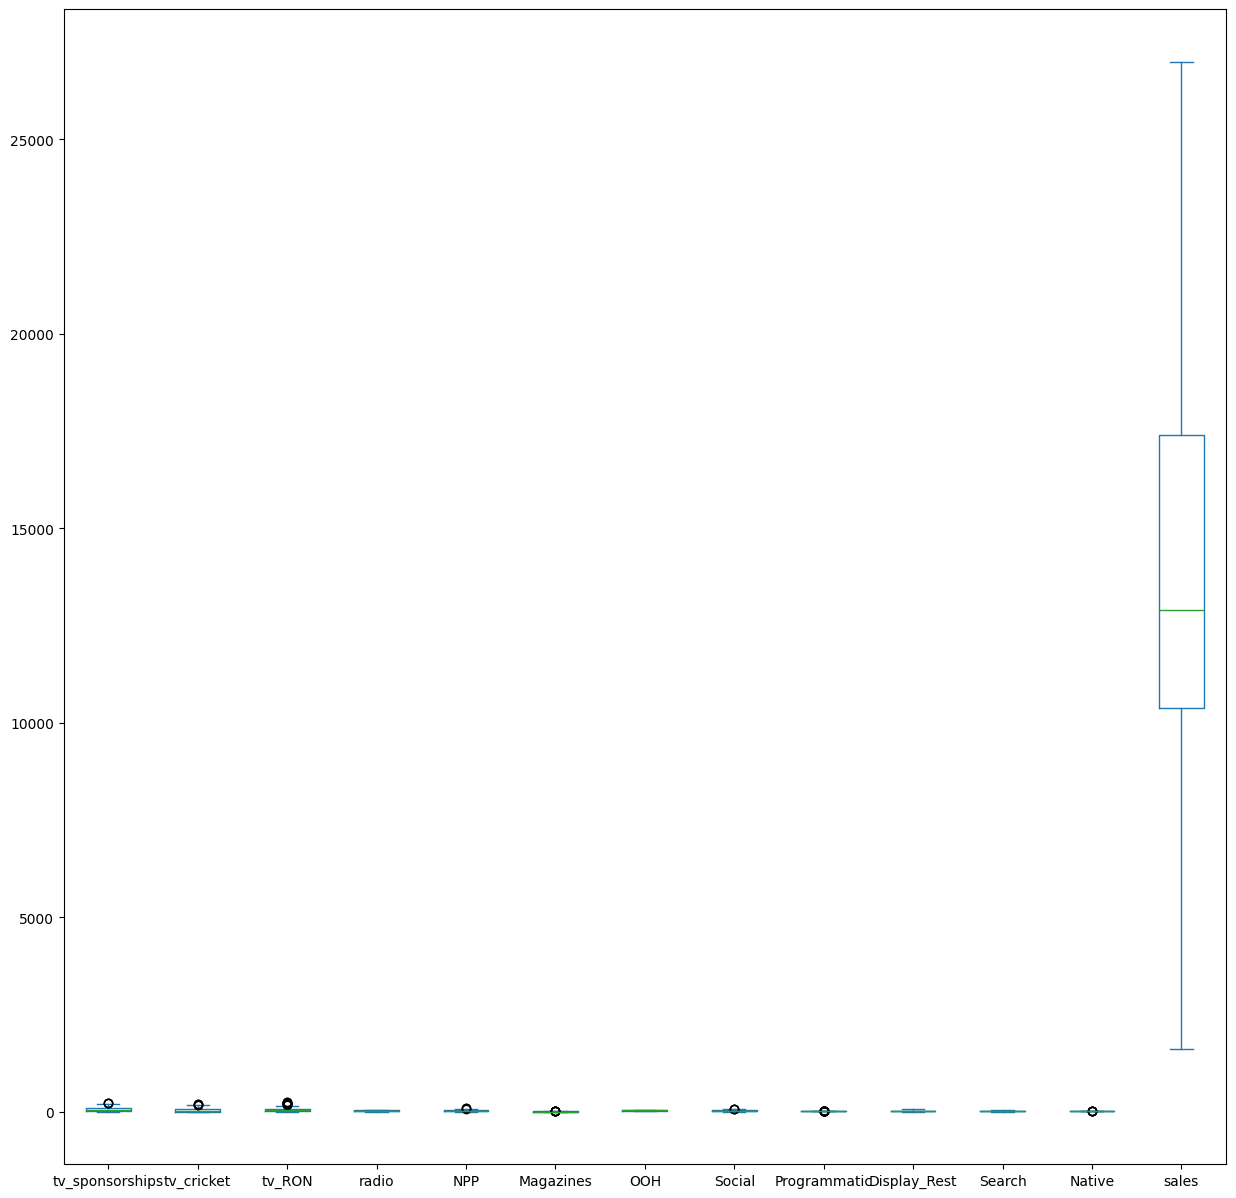

In [5]:
raw_df.plot.box(figsize=(15, 15))

<Axes: >

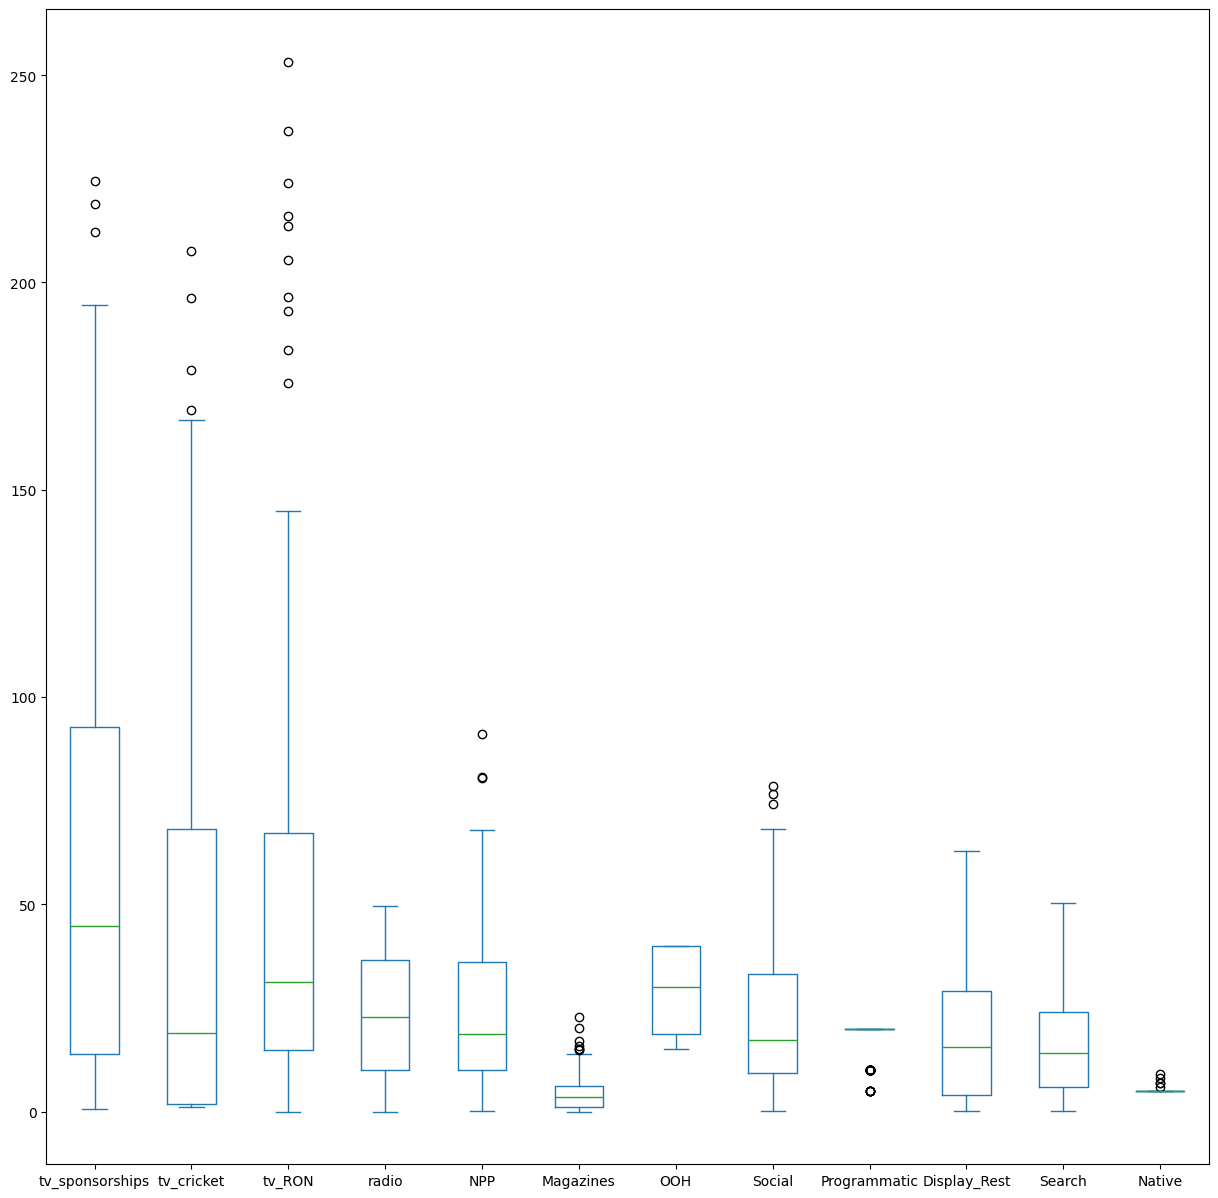

In [6]:
raw_df.drop('sales', axis=1).plot.box(figsize=(15, 15))

In [7]:
raw_df.describe()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales
count,200,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2009-04-16 11:02:24,59.512390,41.657365,51.143055,23.264000,24.372700,4.543300,29.350000,21.925009,17.650000,18.090883,15.664170,5.060000,14022.500000
min,2001-01-01 00:00:00,0.700000,1.000000,0.000000,0.000000,0.270000,0.030000,15.000000,0.245000,5.000000,0.196000,0.156800,5.000000,1600.000000
25%,2005-02-22 00:00:00,14.017500,1.750000,14.935000,9.975000,10.000000,1.015000,18.750000,9.259250,20.000000,3.986500,5.925920,5.000000,10375.000000
50%,2009-04-16 00:00:00,44.705000,19.022000,31.330000,22.900000,18.800000,3.420000,30.000000,17.329375,20.000000,15.584800,14.106848,5.000000,12900.000000
75%,2013-06-08 12:00:00,92.777500,68.286500,67.262500,36.525000,36.080000,6.185000,40.000000,33.302500,20.000000,29.134560,23.966880,5.000000,17400.000000
max,2017-08-01 00:00:00,224.560000,207.480000,253.260000,49.600000,91.200000,22.800000,40.000000,78.596000,20.000000,62.876800,50.301440,9.000000,27000.000000
std,NaN,50.672105,49.165205,52.431041,14.846809,18.054915,4.187503,10.103858,17.342664,4.508785,14.692380,11.355416,0.408945,5217.456566


In [53]:
raw_df.melt(
    id_vars=['Time'],
    value_vars=['tv_sponsorships','tv_cricket','tv_RON',
    'radio','NPP','Magazines','OOH','Social','Programmatic','Display_Rest','Search','Native','sales']
) \
    .groupby('variable') \
        .plot_timeseries(
            'Time', 'value',
            color_column='variable',
            facet_ncol = 2,
            width = 600,
            height = 800,
            legend_show = True
        )

TypeError: `date_column` (Time) is not a datetime64[ns] dtype. Dtype Found: period[M]

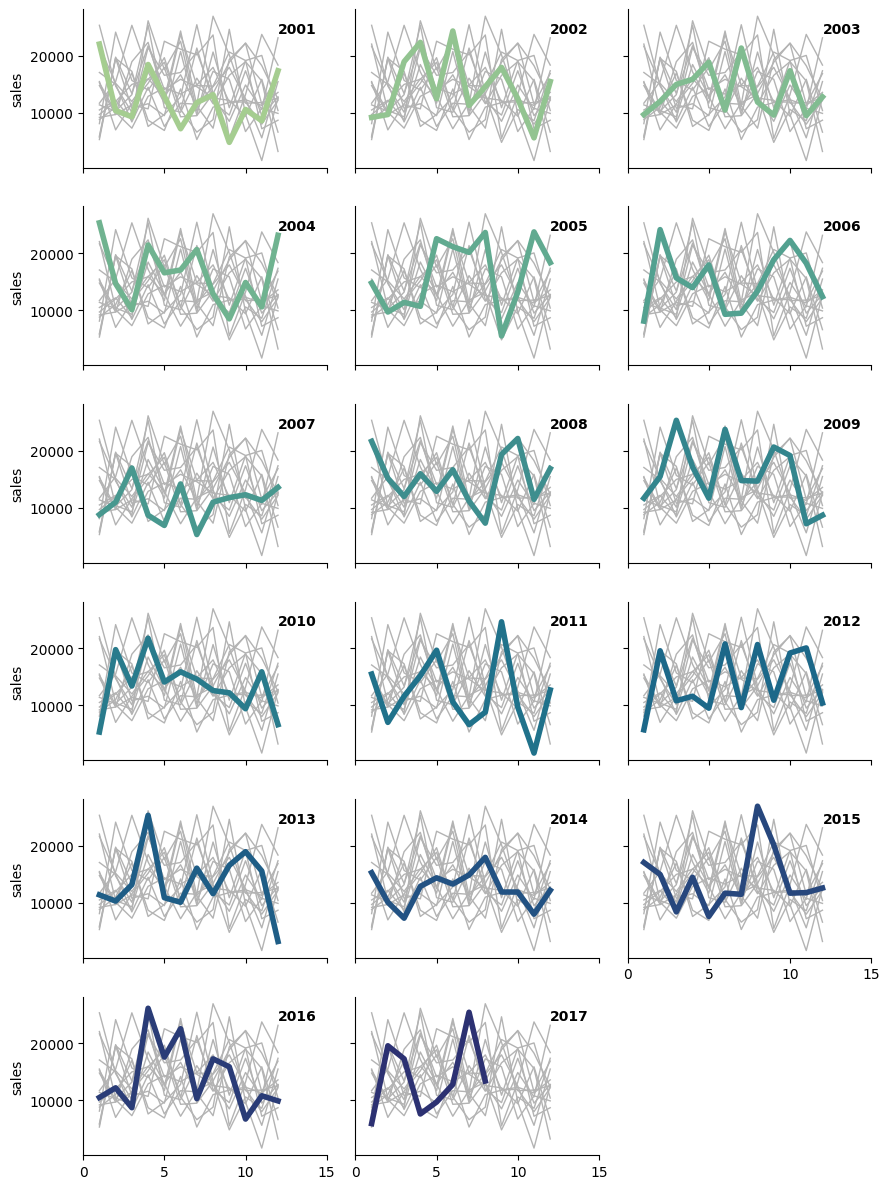

In [10]:
# Plot each year's time series in its own facet
g = sns.relplot(
    data=raw_df,
    x="month", y="sales", col="year", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=raw_df, x="month", y="sales", units="year",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "sales")
g.tight_layout()

While there does not appear to be a discernable seasonality to these sales data, looking at year over year trends in the graphic above, gives a gut sense that the heavy investment in cricket from 2001 to 2008 may have a strong correleation with sales growth during this period. The flatness ov native spending in this period also compremises the model as the lack of variation in spending makes it uninformative.

The above charts comparing revene over time do not yield immediate insights of seasonality in the data but the model may yet yeild something

In [43]:
#Do I need all of the figures presented here to make my case?

total_spend_per_channel =raw_df[['tv_sponsorships','tv_cricket','tv_RON',
    'radio','NPP','Magazines','OOH','Social','Programmatic','Display_Rest','Search','Native']].sum(axis=0)
total_revenue = raw_df.sales.sum()
spend_ratio = total_spend_per_channel / total_spend_per_channel.sum()
print(total_revenue)
print(total_spend_per_channel)
print(total_revenue / total_spend_per_channel)


2804500
tv_sponsorships    11902.478000
tv_cricket          8331.473000
tv_RON             10228.611000
radio               4652.800000
NPP                 4874.540000
Magazines            908.660000
OOH                 5870.000000
Social              4385.001900
Programmatic        3530.000000
Display_Rest        3618.176560
Search              3132.833984
Native              1012.000000
dtype: float64
tv_sponsorships     235.623204
tv_cricket          336.615146
tv_RON              274.181900
radio               602.755330
NPP                 575.336339
Magazines          3086.412960
OOH                 477.768313
Social              639.566428
Programmatic        794.475921
Display_Rest        775.114192
Search              895.195856
Native             2771.245059
dtype: float64


### Preparing to build model

In [44]:
print(spend_ratio)


tv_sponsorships    0.190603
tv_cricket         0.133418
tv_RON             0.163798
radio              0.074508
NPP                0.078059
Magazines          0.014551
OOH                0.094000
Social             0.070220
Programmatic       0.056528
Display_Rest       0.057940
Search             0.050168
Native             0.016206
dtype: float64


In [45]:
p_sigmas = 12 * spend_ratio.to_numpy()

p_sigmas.tolist()

[2.2872309213387667,
 1.6010113747657468,
 1.9655735017150082,
 0.8941018862462939,
 0.9367123900840373,
 0.17461197987374427,
 1.1280042280488618,
 0.8426406615336102,
 0.6783398509390941,
 0.6952842346690437,
 0.6020187358990051,
 0.19447023488678844]

## Modeling

This model will be using the PYMC-Marketing package to generate a baysian model of our data. 

In [11]:

from sklearn.preprocessing import MaxAbsScaler

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

import arviz as az 
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz as gr

In [88]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

As pymc-marketing automatically scales channel and target variables between 1 and zero using scikit-learn MaxAbsScaler but leaves all other variable scaling to the discretion of the user, I will apply the same scaling to our CPI data to ensure the model will perform properly.

In [78]:
scaler = MaxAbsScaler()
data_df['cpi_all_raw'] = scaler.fit_transform(data_df[['cpi_all_raw']])
data_df.rename(columns={'cpi_all_raw':'cpi'}, inplace=True)
data_df.head()

,Time,tv_sponsorships,tv_cricket,tv_RON,radio,NPP,Magazines,OOH,Social,Programmatic,Display_Rest,Search,Native,sales,Chinese New Year,Christmas Day,Deepavali,Eid al-Adha,Eid al-Fitr,Good Friday,Labor Day,National Day,New Year's Day,Polling Day,SG50 Public Holiday,Vesak Day,cpi
0,2001-01,119.652,66.729,43.719,37.8,55.36,13.84,35,41.8782,5,33.50256,26.802048,5,22100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.756126
1,2001-02,23.140,12.905,8.455,39.3,36.08,9.02,35,8.0990,5,6.47920,5.183360,6,10400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.754959
2,2001-03,8.944,4.988,3.268,45.9,55.44,13.86,35,3.1304,5,2.50432,2.003456,7,9300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.756126
3,2001-04,78.780,43.935,28.785,41.3,46.80,11.70,35,27.5730,5,22.05840,17.646720,5,18500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.758460
4,2001-05,94.016,52.432,34.352,10.8,46.72,11.68,35,32.9056,5,26.32448,21.059584,7,12900,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.754959


Before building the model, we need to define the sigmas for or half normal priors that we are fitting to these data. These priors will use their share of overall spend to give greater flexibility of influence  over the target variable to those that have more spending.

In [83]:
data_df['Time'] = data_df['Time'].dt.to_timestamp() #needed as pymc-marketing cannot work with period data types


In [84]:
x = data_df.drop(['sales'], axis=1) #while the other variables will be pulled from data_df, it was easier to write these steps using the raw_df
y = data_df['sales']

In [70]:
mmm_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=p_sigmas),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [47]:
mmm_sampler_config = {"progressbar": True}

In [71]:
#starting off in this instance by assuming that  the effect of an advertizing channel maximizes at exposure and dwindles overtime. Hence the geometric adstock feature.

mmm = MMM(
    model_config=mmm_model_config,
    sampler_config=mmm_sampler_config,
    date_column='Time',
    adstock=GeometricAdstock(l_max=2), #this variable assumes the time window for an ad to hav maximum effect and dwindle  there after. 
    #8 weeks being standard so 2 periods with our monthly data
    saturation=LogisticSaturation(),
    channel_columns=['tv_sponsorships','tv_cricket','tv_RON',
    'radio','NPP','Magazines','OOH','Social','Programmatic','Display_Rest','Search','Native'],
    control_columns = holiday_names.append('cpi')
)

Sampling: [adstock_alpha, intercept, saturation_beta, saturation_lam, y, y_sigma]


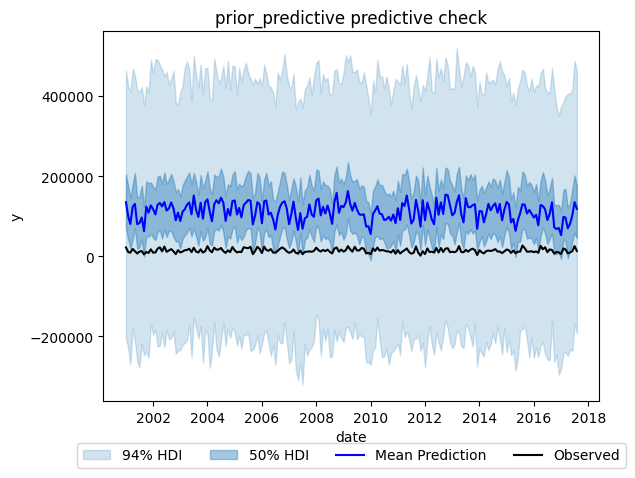

In [ ]:
# Generate prior predictive samples to asses if the model is not too similar to the data before it is set to predict the data
mmm.sample_prior_predictive(x, y, samples=2_000)

fig, ax = plt.subplots()
mmm.plot_prior_predictive(ax=ax, original_scale=True)
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4);

In [89]:
# Make sure to check https://github.com/jax-ml/jax?tab=readme-ov-file#installation on registering my gpu for this

mmm.fit(X=x, y=y, chains=4, target_accept=0.85, nuts_sampler="blackjax", random_seed=rng)

Running window adaptation


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

my model has a divergence so lets keep a close ey on the other diagnostics.

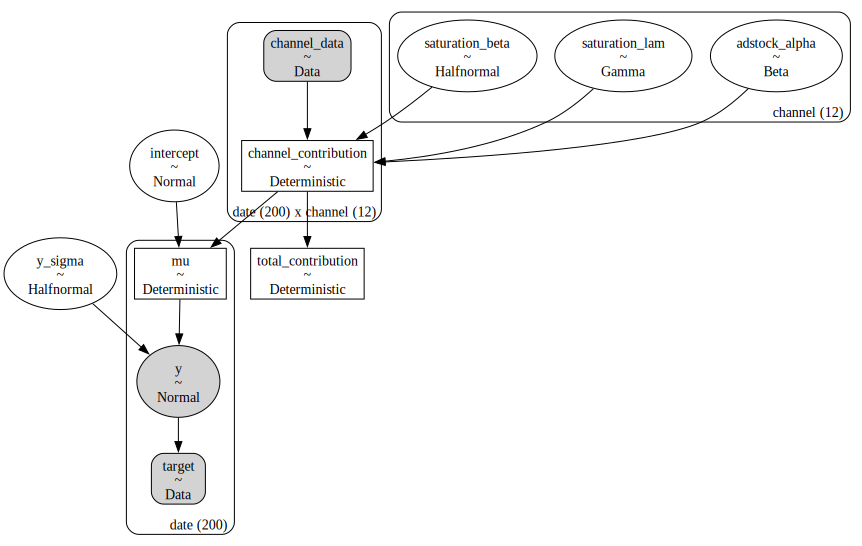

In [90]:
mmm.graphviz()

an explanatory graphic of my model. This is useful more on the analyst end than the client end to determine how the various parts of the model relate to one another and if it is specified properly. Meanwhile, I shall begin a diagnostic.

In [99]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
)

KeyError: 'var names: "[\'gamma_control\' \'gamma_fourier\'] are not present" in dataset'

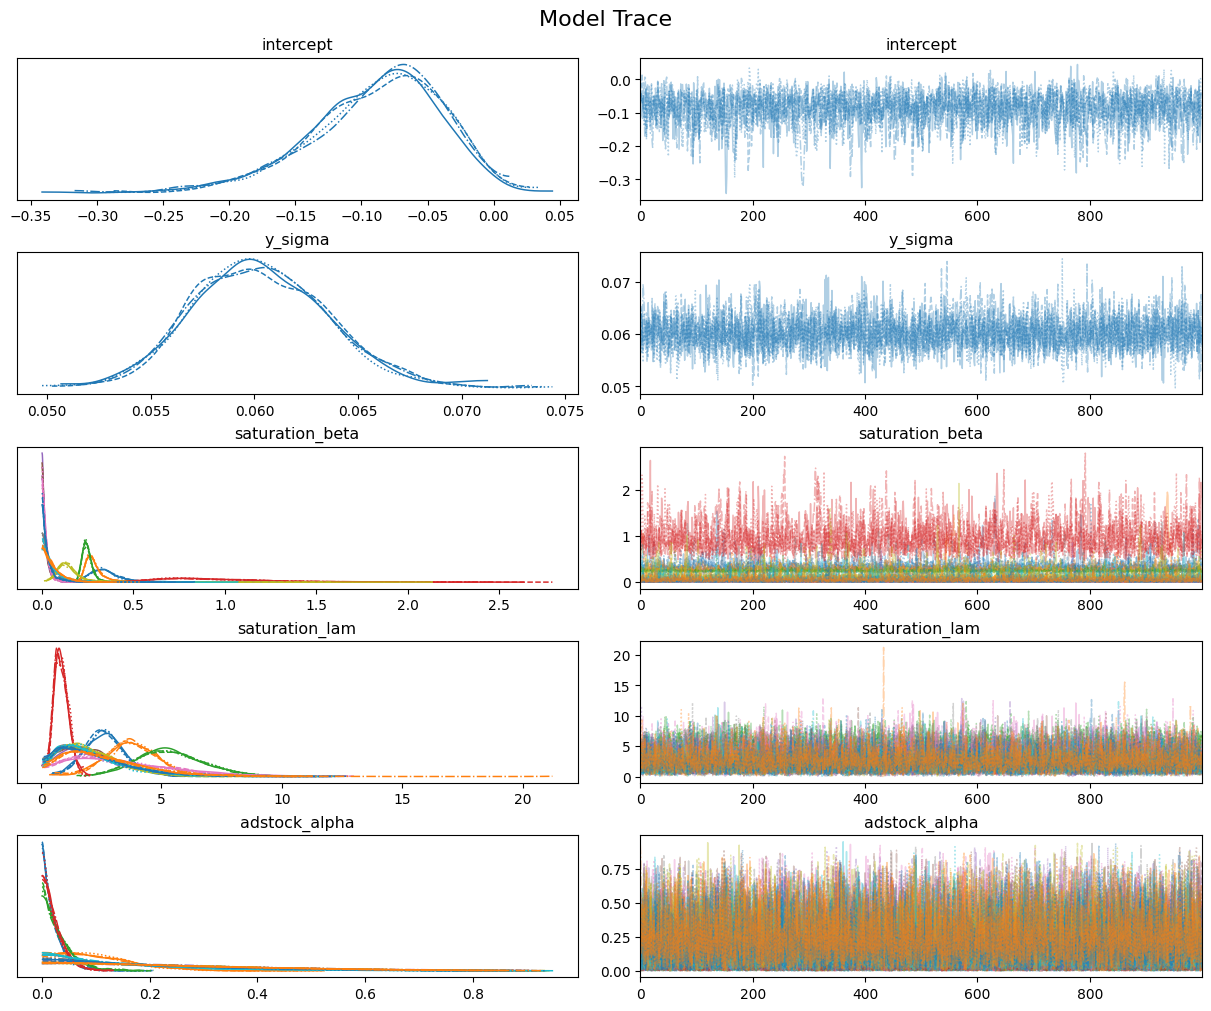

In [92]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
   ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [94]:
mmm.sample_posterior_predictive(x, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 200)
Coordinates:
  * date     (date) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2017-08-01
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 1.55e+04 1.721e+04 ... 1.509e+04
Attributes:
    created_at:                 2025-09-01T00:51:17.447636+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1

Sampling: [y]


Output()

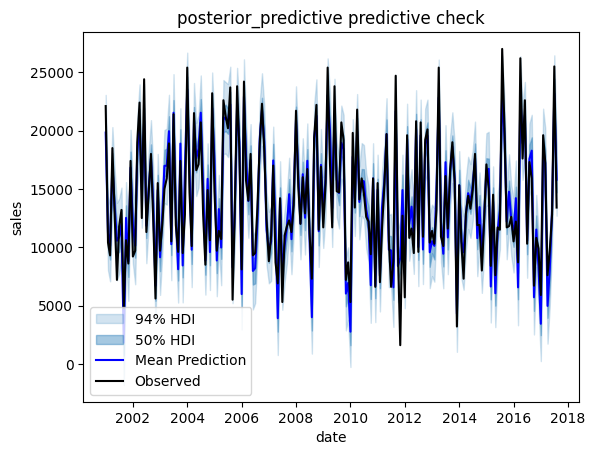

In [96]:
mmm.sample_posterior_predictive(x, extend_idata=True, combined=True)
fig = mmm.plot_posterior_predictive(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales");

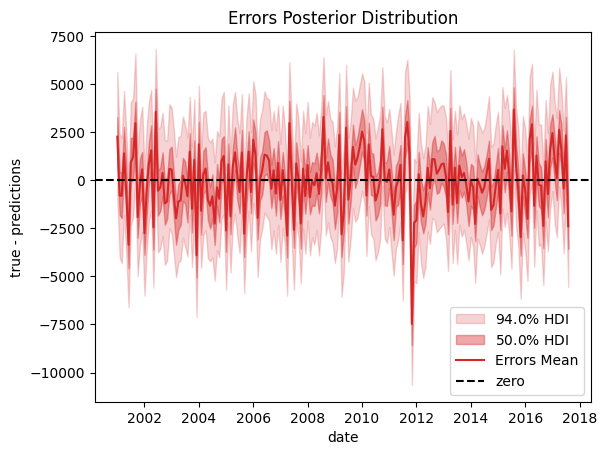

In [97]:
mmm.plot_errors(original_scale=True);

Looking at R-hat and other model diagnostics does not show any obvious issues with the model so we can continue with this exercise.

## Channel Contributions

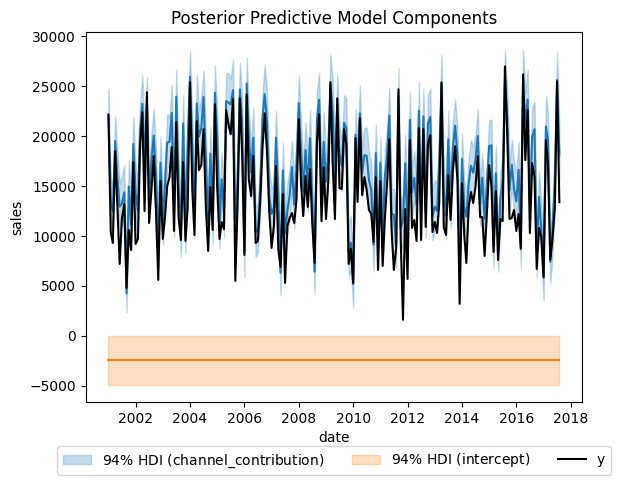

In [98]:
fig = mmm.plot_components_contributions(original_scale=True)
fig.gca().set(xlabel="date", ylabel="sales");

t appears that I have missed something in my specifications as the control vatiables  do not appear in the diagnostic. Will have to determine why.